# ASSIGNMENT 2

##  Create jupyter notebook to replace the user interface (the node "A") and try to using widgets to let the user know the position of the robot and all targets that have been set and cancelled in the enviroment (2a).

## Plot the robot position and add a plot also for the number of reached and cancelled goals (2b).

In [1]:
import rospy
import actionlib
import assignment_2_2023.msg
from std_srvs.srv import *
from nav_msgs.msg import Odometry
from geometry_msgs.msg import Point, Pose, Twist
from assignment_2_2023.msg import msg_struct

# import for assignment 2(a)
from ipywidgets import *
from IPython.display import display, HTML, clear_output, Markdown
import ipywidgets as widgets

# import for assignment 2(b)
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd


In [2]:
# Global variables
finished = False  # Initialize finished variable globally
client = None  # Initialize client globally
goals = []  # List to store goal positions
cancelled_goals = []  # List to store cancelled goal positions
n_reach = 0 # counter for reached goals
n_canc = 0 # counter for cancelled goals
position_data = []


def publish_msg(msg):
    global publisher
    position = msg.pose.pose.position
    velocity = msg.twist.twist.linear
    new_msg = msg_struct()
    new_msg.x = position.x
    new_msg.y = position.y
    new_msg.vel_x = velocity.x
    new_msg.vel_y = velocity.y
    publisher.publish(new_msg)
    

def feedback_callback(feedback):
    global finished, n_reach
    if feedback.stat == "Target reached!":
        finished = True
        n_reach +=1
        update_goal_info()
             

def cancel_goal(button):
    global finished, client, cancelled_goals, n_canc
    if client and not finished:  # Check if client is not None
        if goals:  # Check if there are goals to cancel
            cancelled_goal = goals.pop()
            cancelled_goals.append(cancelled_goal)
        else:
            print("No goals to cancel!")

        client.cancel_goal()
        finished = True
        n_canc+=1
        update_cancelled_goal_info()

def start_client(button, x_input, y_input):
    global finished, client, goals
    client = actionlib.SimpleActionClient('/reaching_goal', assignment_2_2023.msg.PlanningAction)
    client.wait_for_server()

    x = x_input.value
    y = y_input.value
    
    goal = assignment_2_2023.msg.PlanningGoal()
    goal.target_pose.pose.position.x = x
    goal.target_pose.pose.position.y = y

    finished = False
    client.send_goal(goal, None, None, feedback_callback)
    
    # Add the goal position to the list
    goals.append((x, y))
    update_goal_info()
    
# Function telling what the "Set goal" button does
def on_execute_button_clicked(button, x_input, y_input):
    start_client(button, x_input, y_input)

# Functions for updating textareas
def update_goal_info():
    global goals, goal_info
    goal_info.value = ""
    for i, goal in enumerate(goals + cancelled_goals, start=1):
        if goal in goals:
            goal_info.value += f"({goal[0]}, {goal[1]})\n"
        else:
            goal_info.value += f"({goal[0]}, {goal[1]}) [CANCELLED]\n"

def update_cancelled_goal_info():
    global cancelled_goals, cancelled_goal_info
    cancelled_goal_info.value = ""
    reversed_cancelled_goals = list(reversed(cancelled_goals))
    for i, goal in enumerate(reversed_cancelled_goals, start=1):
        cancelled_goal_info.value += f"({goal[0]}, {goal[1]})\n"

# Implementation of class visualiser for displaying robot positions and reach. goals VS canc. goals
class Visualiser:
    def __init__(self):
        self.fig, (self.ax, self.ax2) = plt.subplots(1, 2, figsize=(9, 6))
        plt.subplots_adjust(left=0.05, bottom=0.1, right=0.95, top=0.9, wspace=0.3, hspace=0.2)
        self.ln, = self.ax.plot([], [], color='darkorange', marker='o', markersize=6, label='Current position')
        self.x_data, self.y_data = [], []
        self.goal_plots = []
        self.cancelled_goal_plots = []

        self.ax2.bar(['Reached', 'Cancelled'], [n_reach, n_canc], color=['#40E0D0','#DA70D6'])
        self.ax2.grid(axis='y', linestyle='--', alpha=0.6)
        self.ax2.set_yticks(range(0, 11, 1))
        self.ax2.set_title(label='HOW MANY TARGETS...', fontsize='large', loc='center',
                          fontweight='bold', style='italic', family='monospace', color='red')
        self.ax2.set_xlabel('Kind of goal')
        self.ax2.set_ylabel('Number')

        self.legend_markers = set() # list to track the legend

    def plot_init(self):
        self.ax.set_xlim(10, -10)
        self.ax.set_ylim(10, -10)
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y', rotation=0)
        self.ax.grid(True)
        self.ax.set_title(label='WHERE IS THE ROBOT?', fontsize='large', loc='center',
                          fontweight='bold', style='italic', family='monospace', color='red')
        self.ax.plot([9.5, -9.5, -9.5, 9.5, 9.5], [9.5, 9.5, -9.5, -9.5, 9.5], 'crimson', linewidth=2.5)
        self.ax.plot([4, -5, -5], [-0.5, -0.5, -5], 'palevioletred', linewidth=4)
        self.ax.plot([-7, 5], [4.5, 4.5], 'palevioletred', linewidth=4)

        return self.ln

    def odom_callback(self, msg):
        self.y_data.append(msg.pose.pose.position.y)
        self.x_data.append(msg.pose.pose.position.x)

   
    def update_plot(self, frame):
        goals_x = [goal[0] for goal in goals]
        goals_y = [goal[1] for goal in goals]
        cancelled_goals_x = [goal[0] for goal in cancelled_goals]
        cancelled_goals_y = [goal[1] for goal in cancelled_goals]
    
        for goal_plot in self.goal_plots:
            goal_plot.remove()
        for cancelled_goal_plot in self.cancelled_goal_plots:
            cancelled_goal_plot.remove()
    
        self.goal_plots = []  
        self.cancelled_goal_plots = []  

        # Plot of goals
        for i, (goal_x, goal_y) in enumerate(zip(goals_x, goals_y)):
            if (goal_x, goal_y) in cancelled_goals:
                color = 'red'
                marker = 's'
                label = 'Set, Cancelled and re-set Goal' # added because sometimes there could be errors
            elif i == len(goals) - 1 and not finished:
                color = 'blue'
                marker = 'v'
                label = 'Current Goal'
            elif i == len(goals) - 1 and finished:
                color = '#40E0D0'
                marker = 'x'
                label = 'Past Reached Goal'
            else:
                color = '#40E0D0'  
                marker = 'x'
                label = 'Past Reached Goals'
            
            # Check for the legend
            if marker not in self.legend_markers:
                self.ax.plot([], [], marker, color=color, label=label)
                self.legend_markers.add(marker)
            goal_plot = self.ax.plot(goal_x, goal_y, marker, color=color)  
            self.goal_plots.append(goal_plot[0]) 
        

        for cancelled_goal_x, cancelled_goal_y in zip(cancelled_goals_x, cancelled_goals_y):
            if '1' not in self.legend_markers:
                self.ax.plot([], [], '1', color='#DA70D6', label='Cancelled Goals')
                self.legend_markers.add('1')
            cancelled_goal_plot = self.ax.plot(cancelled_goal_x, cancelled_goal_y, '1', color='grey')  
            self.cancelled_goal_plots.append(cancelled_goal_plot[0]) 

        self.ln.set_data(self.x_data, self.y_data)
    
        self.ax2.bar(['Reached', 'Cancelled'], [n_reach, n_canc], color=['#40E0D0', '#DA70D6'])

        self.ax.legend()

        return self.ln



In [3]:
%matplotlib notebook

# Starting the node
rospy.init_node('action_client')
publisher = rospy.Publisher("/position_velocity", msg_struct, queue_size=1)


# Starting construction of my interface 
instruction_text0 = widgets.HTML(value="<h2 style='color:white; text-align:center; font-weight: bold; fontfont-family: italic'> ROBOT CONTROL INTERFACE </h2>")

# Aggiungi il CSS per la cornice rosa intorno a instruction_text0
instruction_text0_style = """
    border: 6px solid #C20078;
    border-radius: 5px;
    padding: 5px;
    background-color: #C20078;
"""

# Applica lo stile CSS a instruction_text0
instruction_text0.value = f"<div style='{instruction_text0_style}'>{instruction_text0.value}</div>"


instruction_text1 = widgets.HTML(value="<h4>Please, provide the coordinates:</h4>")

x_input = widgets.BoundedFloatText(value=0, min=-9.0, max=9.0, step =0.1, bar_style='info')
y_input = widgets.BoundedFloatText(value=0, min=-9.0, max=9.0,step=0.1, bar_style='info')


# Modify the width of the widgets
x_input.layout.width = '100px' 
y_input.layout.width = '100px' 
    
# Buttons
execute_button = widgets.Button(value=False, 
                                    description="Set Goal", 
                                    disabled=False, 
                                    button_style='info',
                                    icon='play')
execute_button.on_click(lambda b: on_execute_button_clicked(b, x_input, y_input))
    
instruction_text2 = widgets.HTML(value="<h4>Press the button if you want to cancel the goal: </h4>")

cancel_button = widgets.Button(value=False, 
                                   description="Cancel Goal",
                                   disabled=False,
                                   button_style='danger',
                                   icon='times')
cancel_button.on_click(cancel_goal)

# Textareas
goal_info = widgets.Textarea(
        value="",
        description="Setted:",
        disabled=True 
    )
    
cancelled_goal_info = widgets.Textarea(
        value="",
        description="Cancelled:",
        disabled=True
    )


Output(layout=Layout(border='2px solid pink', padding='10px'))

<IPython.core.display.Javascript object>


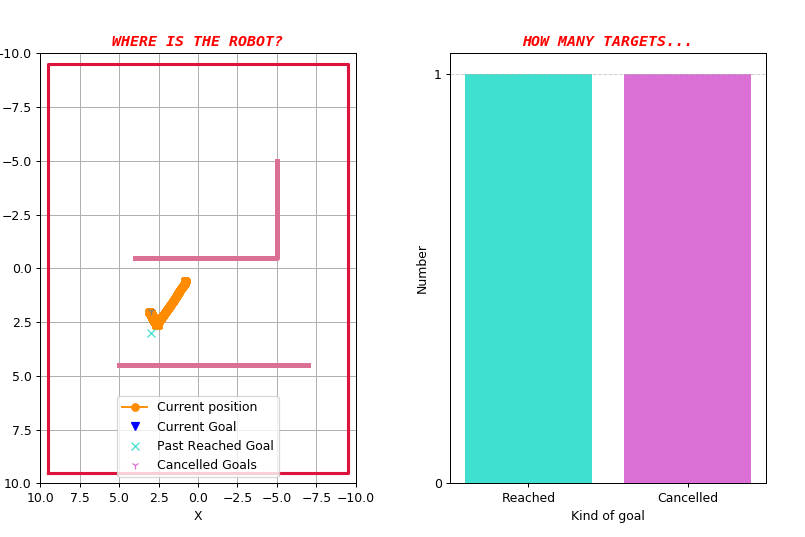

In [4]:
output_widget = widgets.Output(layout={'border': '2px solid pink', 'padding': '10px', 'border-radius': '10px', 'background-color': 'pink'})

def show_content():
    display(widgets.VBox([instruction_text0, widgets.HBox([instruction_text1, widgets.HBox([x_input, y_input]), execute_button,goal_info ]),
                          widgets.HBox([instruction_text2, cancel_button, cancelled_goal_info])]))

with output_widget:
    display(HTML('<style>.output_wrapper { border-radius: 10px; }</style>'))


with output_widget:
    show_content()

# Mostrare l'output_widget
display(output_widget)


vis = Visualiser()
sub = rospy.Subscriber('/odom', Odometry, vis.odom_callback)
ani = FuncAnimation(vis.fig, vis.update_plot, init_func=vis.plot_init, save_count=100) 



plt.show(block=True)


